# HealthBot: Intelligent Medical Education System

**Author: Ricard Santiago Raigada García**

This notebook implements a LangGraph flow that:
- Receives a patient query.
- Performs a medical search using Tavily.
- Subsequently, the results are summarized in user-friendly language.
- A questionnaire is created to assess the patient's understanding.
- A grade is then returned based on the responses obtained from the medical search using Tavily.
- Finally, it allows the user to continue learning or log out.

# Setup

In [1]:
import time 
from langgraph.graph import MessagesState, START, StateGraph, END
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig
from IPython.display import Image, display
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from tavily import TavilyClient
from typing import Literal
from dotenv import load_dotenv
import os 
from IPython.display import Markdown, display

load_dotenv('config.env')
assert os.getenv('OPENAI_API_KEY') is not None
assert os.getenv('TAVILY_API_KEY') is not None

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)
model = ChatOpenAI(temperature=0, streaming=True)

## Helpers

In [2]:
def display_text_to_user(text: str) -> None:
    """
    Display text to the user with a brief pause.
    
    Parameters
    ----------
    text : str
        The text to display to the user.
    """
    display(Markdown("""
---
### 🤖 HealthBot Response
"""))
    display(Markdown(text))
    time.sleep(1)


def ask_user_for_input(input_description: str) -> str:
    """
    Ask the user for input and return the response

    Parameters
    ----------
    input_description : str
        The description of the input to ask from the user

    Returns
    -------
    str
        The user's response
    """
    display(Markdown("""
---
### 🧠 Patient Interaction
"""))
    display(Markdown(f"**{input_description.strip()}**"))
    response = input().strip().lower()
    return response

## State LangGraph Flow

In [3]:
class State(MessagesState):
    question: str
    search_results: dict
    summary: str
    action: Literal["show_summary", "generate_quiz_question"]
    quiz_question: str = ""
    patient_answer: str = ""
    grade: str = ""

## Utils

In [4]:
def stream_and_store(state: State, prompt: str, save_key: str) -> str:
    """
    Stream a response from the LLM, print it, update messages, and store the result in state.
    
    Parameters
    ----------
    state : State
        The current LangGraph state
    prompt : str
        The prompt to send to the LLM
    save_key : str
        The key in the state dictionary where the result will be saved (e.g., "summary", "quiz_question", etc.)
    
    Returns
    -------
    str
        The full generated response
    """
    chunks = []
    paragraph_buffer = ""
    
    for chunk in llm.stream([HumanMessage(content=prompt)]):
        paragraph_buffer += chunk.content
        if any(end in paragraph_buffer for end in [". ", "\n", "? ", "! "]):
            display(Markdown(paragraph_buffer.strip()))
            time.sleep(0.7)
            chunks.append(paragraph_buffer)
            paragraph_buffer = ""

    if paragraph_buffer.strip():
        display(Markdown(paragraph_buffer.strip()))
        chunks.append(paragraph_buffer)

    result = "".join(chunks)
    state[save_key] = result
    state["messages"] += [HumanMessage(content=prompt), AIMessage(content=result)]
    return result



## Nodes

In [5]:
def ask_health_topic(state: State) -> State:
    """
    Ask the user for a health topic to learn about
    Parameters
    ----------
    state : State
        The current state of the conversation
    Returns
    -------
    State
        The updated state with the user's question
    """
    display_text_to_user("Welcome to HealthBot!")
    topic = ask_user_for_input("What health topic or medical condition would you like to learn about?\n")
    
    state["question"] = topic
    state["messages"].append({"role": "user", "content": topic})
    return state


def search_tavily(state: State) -> dict:
    """
    Search for information on the given health topic using Tavily API
    Parameters
    ----------
    state : State
        The current state of the conversation
    Returns
    -------
    dict
        The updated state with the search results
    """
    tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))
    response = tavily_client.search(state["question"])
    state["search_results"] = response
    return state


def summarize_results(state: State) -> dict:
    """
    Summarizes the search results into a patient-friendly summary
    
    Parameters
    ----------
    state : State
        The current state of the conversation
    Returns
    -------
    dict
        The updated state with the summary
    """
    raw_results = state["search_results"]
    content = "\n".join([r["content"] for r in raw_results["results"]])

    prompt = (
        "Summarize the following medical information in a clear, simple, and patient-friendly way. "
        "Assume the reader has no medical or technical background. Focus on making the content easy to understand, "
        "highlighting the most important points for a general audience:\n\n"
        f"{content}"
    )

    stream_and_store(state, prompt, "summary")
    return state


def comprehension_router(state: dict) -> str:
    """
    Determines the next action based on user readiness for assessment
    
    Parameters
    ----------
    state : dict
        The current state of the conversation
    Returns
    -------
    str
        The next action to take in the conversation flow
    """
    user_input = ask_user_for_input("\nAre you ready to take an assessment? (yes/no): ")
    return "generate_quiz_question" if user_input == "yes" else "summarize_results"


def generate_quiz_question(state: State) -> dict:
    """
    Generates a comprehension question based on the medical summary
    
    Parameters
    ----------
    state : State
        The current state of the conversation
    Returns
    -------
    dict
        The updated state with the generated quiz question
    """
    prompt = (
        "Based solely on the following medical summary, generate a single, clear multiple-choice comprehension question "
        "with four answer options (A, B, C, D). Do not indicate which option is correct, and do not include the answer. "
        "Your output should include only the question and the four answer choices, properly formatted for display.\n\n"
        f"{state['summary']}"
    )


    stream_and_store(state, prompt, "quiz_question")
    return state


def get_patient_answer(state: State) -> dict:
    """
    Asks the patient to provide their answer to the quiz question
    
    Parameters
    ----------
    state : State
        The current state of the conversation
    Returns
    -------
    dict
        The updated state with the patient's answer recorded
    """
    answer = ask_user_for_input("\nYour answer: ")
    state["patient_answer"] = answer
    state["messages"] = state["messages"] + [HumanMessage(content=answer)]
    return state


def grade_answer(state: State) -> dict:
    """
    Grades the patient's answer to the quiz question and provides feedback
    
    Parameters
    ----------
    state : State
        The current state of the conversation
    Returns
    -------
    dict
        The updated state with the grade and feedback
    """
    prompt = (
        "Evaluate the following patient response to a question based on a medical summary. "
        "Assign a letter grade (A, B, C, etc.) and provide a brief explanation for the grade, using only the summary as your source of truth.\n\n"
        f"Medical Summary:\n{state['summary']}\n\n"
        f"Question:\n{state['quiz_question']}\n\n"
        f"Patient's Answer:\n{state['patient_answer']}"
    )
    stream_and_store(state, prompt, "grade")
    return state


def ask_to_continue_or_exit(state: State) -> str:
    """
    Asks the user if they want to learn about another topic or exit the bot
    Parameters
    ----------
    state : State
        The current state of the conversation
    Returns
    -------
    str
    """
    ask = ask_user_for_input("\nDo you want to learn about another topic? (yes/no): ")
    return "reset_state" if ask == "yes" else "end_health_bot"


def reset_state(state: State) -> dict:
    """
    Resets the state to allow the user to ask a new question
    
    Parameters
    ----------
    state : State
        The current state of the conversation
    Returns
    -------
    dict
        The reset state with initial values
    """
    topics = llm.invoke([
        SystemMessage(content=(
            "You are a healthcare education assistant. "
            "Given a medical topic from a patient, suggest 4–6 closely related health topics or conditions "
            "they might also be interested in learning about. "
            "Respond with a comma-separated list of topics only."
        )),
        HumanMessage(content=state["question"])
    ]).content

    topics_list = [t.strip() for t in topics.split(",") if t.strip()]
    if topics_list:
        display_text_to_user("\nRelated Health Topics:\n" + "\n".join(f"- {t}" for t in topics_list))
    else:
        display_text_to_user("No related topics were found.")

    return {
        "question": "",
        "answer": "",
        "search_results": None,
        "summary": "",
        "quiz_question": "",
        "patient_answer": "",
        "grade": "",
        "messages": []
    }


def end_health_bot(state: State) -> dict:
    """
    Ends the HealthBot conversation and thanks the user
    Parameters
    ----------
    state : State
        The current state of the conversation
    Returns
    -------
    dict
        The final state of the conversation
    """
    return display_text_to_user("\nThanks for using HealthBot. See you later!")

## LangGraph Graph

In [6]:
workflow = StateGraph(State)

### Nodes

In [7]:
workflow.add_node("ask_health_topic", ask_health_topic)
workflow.add_node("search_tavily", search_tavily)
workflow.add_node("summarize_results", summarize_results)
workflow.add_node("generate_quiz_question", generate_quiz_question)
workflow.add_node("get_patient_answer", get_patient_answer)
workflow.add_node("grade_answer", grade_answer)
workflow.add_node("reset_state", reset_state)
workflow.add_node("end_health_bot", end_health_bot)

### Edges

In [8]:
workflow.add_edge(START, "ask_health_topic")
workflow.add_edge("ask_health_topic", "search_tavily")
workflow.add_edge("search_tavily", "summarize_results")
workflow.add_conditional_edges(
    source="summarize_results",
    path=comprehension_router,
    path_map=["summarize_results", "generate_quiz_question"],
)
workflow.add_edge("generate_quiz_question", "get_patient_answer")
workflow.add_edge("get_patient_answer", "grade_answer")
workflow.add_conditional_edges(
    source="grade_answer",
    path=ask_to_continue_or_exit,
    path_map=["reset_state", "end_health_bot"],
)
workflow.add_edge("reset_state", "ask_health_topic")
workflow.add_edge("end_health_bot", END)



## Inicialition and Run

In [9]:
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
config = RunnableConfig(recursion_limit=2000, configurable={"thread_id": "1"})  
initial_state = State(messages=[], example="")

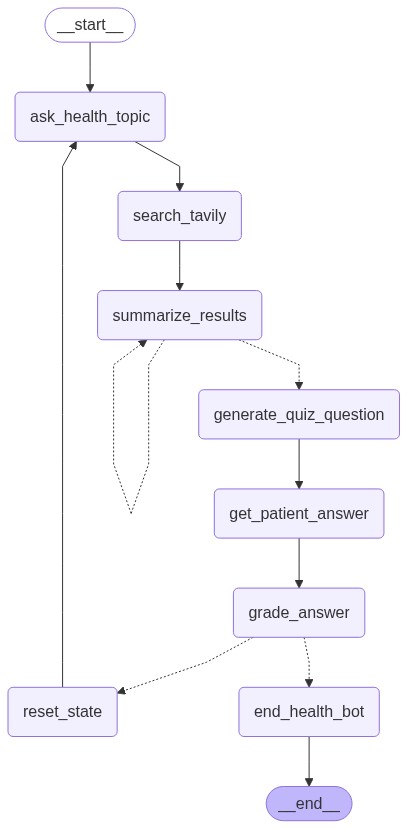

In [10]:
display(Image(app.get_graph().draw_mermaid_png()))

In [11]:
def run_health_bot() -> State:
    """
    Runs the HealthBot application, starting the conversation and managing the state.
    Returns
    -------
    State
        The final state of the conversation after the bot has completed its tasks.
    """
    state = app.invoke(initial_state, config=config)
    return state

run_health_bot()


---
### 🤖 HealthBot Response


Welcome to HealthBot!


---
### 🧠 Patient Interaction


**What health topic or medical condition would you like to learn about?**

asma


**Understanding Asthma: A Simple Guide**

Asthma is a long-term lung condition that makes it hard to breathe. It

happens when the airways in your lungs become narrow, swollen, and filled with extra mucus. This

can lead to symptoms like coughing, wheezing, and feeling short of breath.

### Key Points About Asthma:

- **Chronic Condition**: Asthma is ongoing and doesn't go away on its own. It

requires regular medical care and management.

- **Symptoms**: Common signs of asthma include:

- Difficulty breathing

- Coughing, especially at night or during exercise

- Wheezing (a whistling sound when you breathe)

- **Asthma Attacks**: Sometimes, asthma symptoms can suddenly get worse, leading to an asthma attack. During

an attack, it becomes very hard to breathe, and you may cough or wheeze more than usual.

- **Causes**: Asthma can be triggered by various factors, including allergies, exercise, cold air, and smoke.

- **Management**: While asthma can't be prevented, you can work with your doctor to create a personalized asthma action plan. This

plan will help you manage your symptoms and know what to do during an asthma attack.

- **When to See a Doctor**: If your symptoms worsen or if you find yourself needing your rescue inhaler (like albuterol) more often, it's important to consult your doctor.

### Conclusion

Living with asthma means staying informed and prepared. By

working closely with your healthcare team, you can manage your condition effectively and lead a healthy life.


---
### 🧠 Patient Interaction


**Are you ready to take an assessment? (yes/no):**

yes


What is a common symptom of asthma?

A) Increased energy levels

B) Difficulty breathing

C) Improved lung capacity

D) Enhanced sense of smell


---
### 🧠 Patient Interaction


**Your answer:**

b


Grade: A

Explanation: The patient's response correctly identifies "Difficulty breathing" (option B) as a common symptom of asthma, which is explicitly mentioned in the medical summary. This

demonstrates a clear understanding of the condition and its symptoms, warranting a top grade.


---
### 🧠 Patient Interaction


**Do you want to learn about another topic? (yes/no):**

no



---
### 🤖 HealthBot Response



Thanks for using HealthBot. See you later!

{'messages': [HumanMessage(content='asma', id='e7f77ad6-0c71-48b1-b0a7-bfb874ee41de'),
  HumanMessage(content='asma', id='d91d8974-c6b5-485b-a7dc-4f9953bb2e73'),
  HumanMessage(content="Summarize the following medical information in a clear, simple, and patient-friendly way. Assume the reader has no medical or technical background. Focus on making the content easy to understand, highlighting the most important points for a general audience:\n\nGiving Careers Search ClevelandClinic.org Find A Doctor Locations & Directions Patients & Visitors Health Library Institutes & Departments Appointments Home/ Health Library/ Diseases & Conditions/ Asthma Advertisement Advertisement Asthma Bronchial asthma (or asthma) is a lung disease. Your airways get narrow and swollen and are blocked by excess mucus. Asthma, also called bronchial asthma, is a disease that affects your lungs. It’s a chronic (ongoing) condition, meaning it doesn’t go away and needs ongoing medical management. Asthma can be life-